# Going Deeper(CV) - 6. 나를 찾아줘 - Class Activation Map 만들기

CAM을 활용하여 물체의 위치를 찾아보자.

---

### 루브릭 평가 기준

1. CAM을 얻기 위한 기본 모델의 구성과 학습 진행 - ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습 과정이 안정적으로 수렴하였나
2. 분류 근거를 설명 가능한 Class Activation Map - CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영하였나
3. 인식결과의 시각화 및 성능 분석 수행 - CAM과 Grad-CAM 각각에 대해 원본 이미지 합성, 바운딩 박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교 분석되었나

---

### 목차

0) 필요 모듈 import


1) 데이터 로드


2) CAM 모델 기본 구조


3) CAM 생성


4) Detection
  - with CAM
  - with Grad-CAM
  
  
5) 결과 정리


6) 회고

## 0. 필요 모듈 import

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

from os import path
from google.colab import drive

print("완료 (๑>ᴗ<๑)")

완료 (๑>ᴗ<๑)


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. 데이터 로드

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

print("완료 (๑>ᴗ<๑)")

완료 (๑>ᴗ<๑)


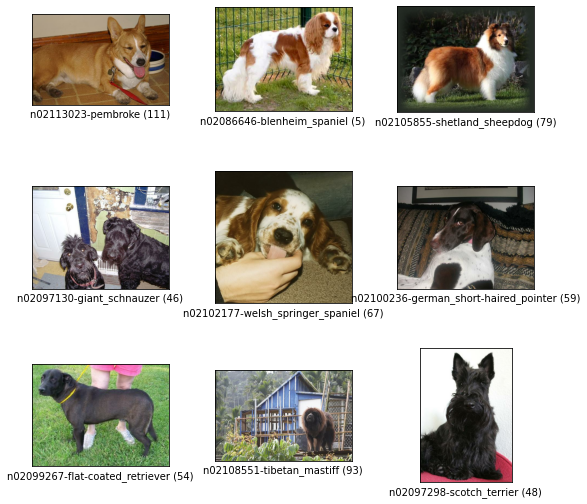

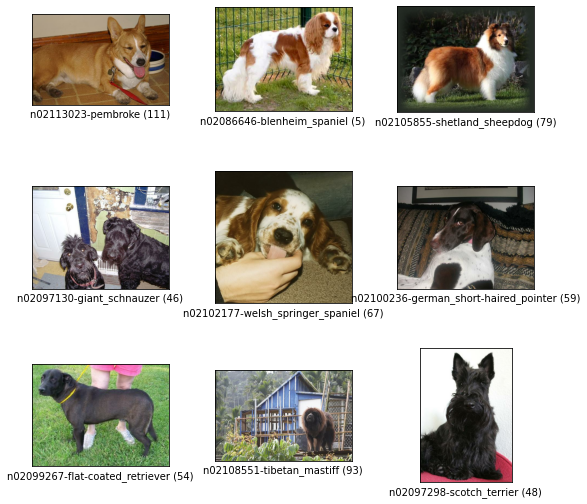

In [4]:
tfds.show_examples(ds_train, ds_info)

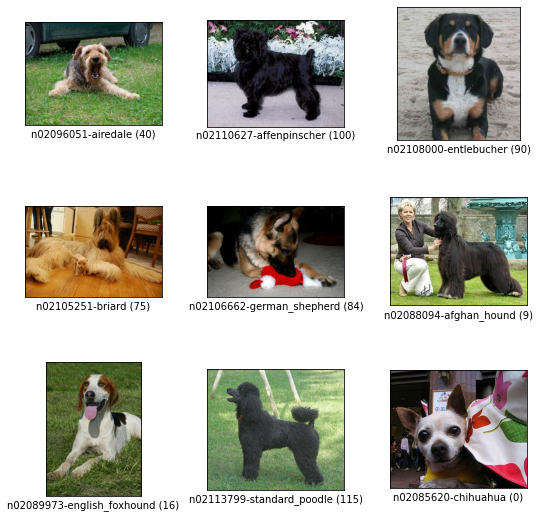

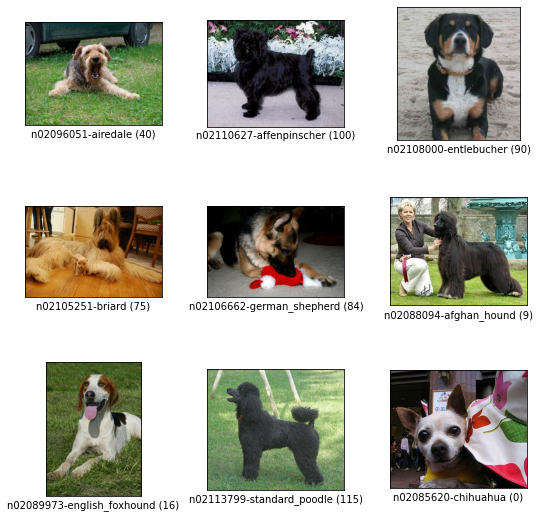

In [5]:
tfds.show_examples(ds_test, ds_info)

In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

## 2. CAM 모델 기본 구조

ResNet 50 뒤에 필요한 레이어를 이어붙여 CAM 구조를 위한 기본 모델을 만들어 보자.

In [7]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

마지막 fully connected layer 대신 GAP을 사용해야한다.  
ResNet50의 매개변수 pooling에 'avg'를 매개변수로 전달함으로써 GAP 연산을 붙여준다.

In [8]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print("완료 (๑>ᴗ<๑)")

완료 (๑>ᴗ<๑)


In [10]:
# 데이터셋에 전처리와 배치처리를 적용
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [11]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

print("완료 (๑>ᴗ<๑)")

완료 (๑>ᴗ<๑)


In [12]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=20,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 103s 125ms/step - loss: 2.1855 - accuracy: 0.4505 - val_loss: 3.2913 - val_accuracy: 0.2298
Epoch 2/20
750/750 [==============================] - 91s 122ms/step - loss: 0.6826 - accuracy: 0.8167 - val_loss: 1.3796 - val_accuracy: 0.6170
Epoch 3/20
750/750 [==============================] - 91s 121ms/step - loss: 0.1895 - accuracy: 0.9645 - val_loss: 0.9671 - val_accuracy: 0.7178
Epoch 4/20
750/750 [==============================] - 91s 122ms/step - loss: 0.0463 - accuracy: 0.9974 - val_loss: 0.8997 - val_accuracy: 0.7378
Epoch 5/20
750/750 [==============================] - 91s 122ms/step - loss: 0.0200 - accuracy: 0.9997 - val_loss: 0.9084 - val_accuracy: 0.7404
Epoch 6/20
750/750 [==============================] - 91s 122ms/step - loss: 0.0129 - accuracy: 1.0000 - val_loss: 0.9311 - val_accuracy: 0.7374
Epoch 7/20
750/750 [==============================] - 91s 122ms/step - loss: 0.0114 - accuracy: 0.9999 - val_loss: 0.9824 - val_a

In [13]:
drive.mount('/content/drive', force_remount=True)

cam_model_path = "/content/drive/MyDrive/ColabNotebooks/GoingDeeper/06/cam_model.h5"
cam_model.save(cam_model_path)
print("저장 완료 (๑>ᴗ<๑)")

Mounted at /content/drive
저장 완료 (๑>ᴗ<๑)


## 3. CAM 생성

### - CAM

데이터셋에서 개별 이미지를 뽑을 수 있는 함수를 정의한다.

In [14]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print("완료 (๑>ᴗ<๑)")

완료 (๑>ᴗ<๑)


80


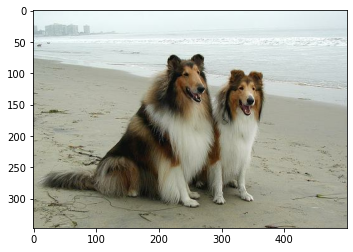

In [15]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

위 과정에서 학습된 모델을 불러와 사용하자.

In [16]:
cam_model_path = "/content/drive/MyDrive/ColabNotebooks/GoingDeeper/06/cam_model.h5"
cam_model = tf.keras.models.load_model(cam_model_path)

print("완료 (๑>ᴗ<๑)")

완료 (๑>ᴗ<๑)


generate_cam() 을 구현하기 위해 아래에서는 conv_ouputs와 같이 특정 레이어의 결과값을 output으로 받기 위한 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 한다.  
마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize해준다.

In [17]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해 모델의 input과 output을 새롭게 정의
    # model.layers[-3].output : 우리가 필요로 하는 GAP 이전 Convolution layer의 output
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize
    return cam_image

print("완료 (๑>ᴗ<๑)")

완료 (๑>ᴗ<๑)


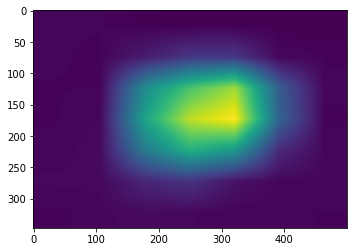

In [18]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

CAM 이미지와 원본 이미지를 합치는 함수를 정의한다.

In [19]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print("완료 (๑>ᴗ<๑)")

완료 (๑>ᴗ<๑)


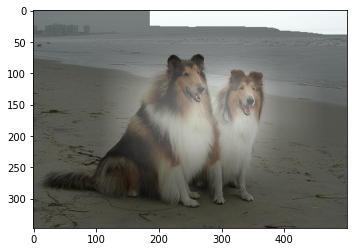

In [20]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

생성된 CAM이 개를 식별하는데 중요한 부분을 잘 파악하고 있다.

### - Grad-CAM

위에서 만들었떤 모델을 그대로 다시 활용하여 Grad-CAM을 이용해 CAM을 얻어보자.

In [21]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값
        output = conv_output[0] # 원하는 layer의 output
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print("완료 (๑>ᴗ<๑)")

완료 (๑>ᴗ<๑)


67


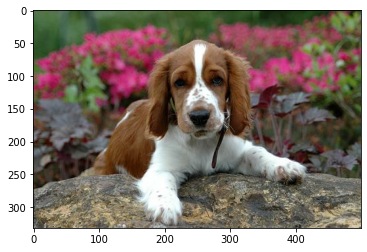

In [22]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

#### conv5_bloc3_out 이용

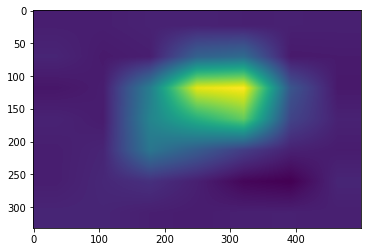

In [23]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

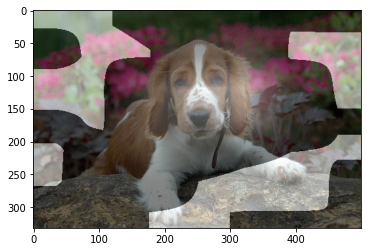

In [24]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

#### conv4_bloc3_out 이용

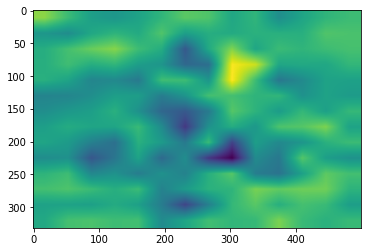

In [25]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

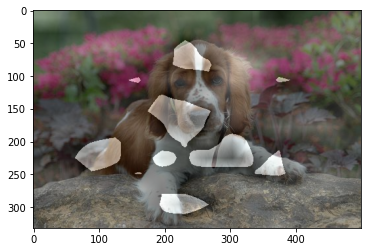

In [26]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

#### conv3_bloc3_out 이용

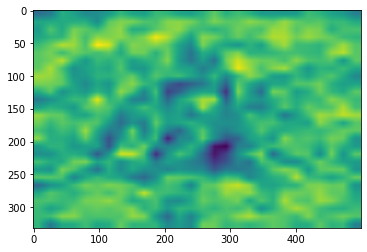

In [27]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

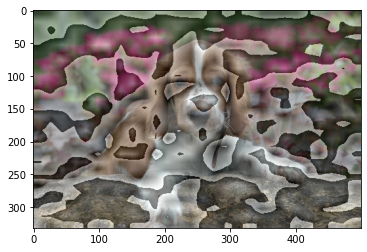

In [28]:
origin_image = item['image'].astype(np.uint8)
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(grad_cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

## 4. Detection

### - with CAM

67


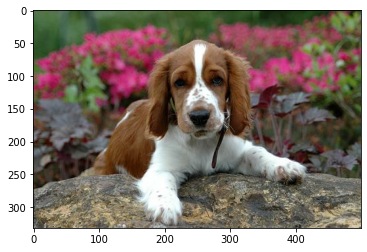

In [29]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

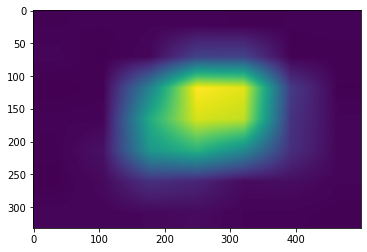

In [30]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [31]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print("완료 (๑>ᴗ<๑)")

완료 (๑>ᴗ<๑)


In [32]:
rect = get_bbox(cam_image)
rect

array([[109, 292],
       [109,  36],
       [440,  36],
       [440, 292]])

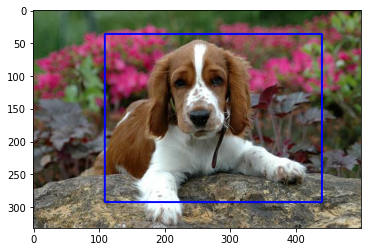

In [33]:
image = copy.deepcopy(item['image'])
output_cam = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(output_cam)
plt.show()

In [34]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print("완료 (๑>ᴗ<๑)")

완료 (๑>ᴗ<๑)


In [35]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.10843373493975904, 0.218, 0.8795180722891566, 0.88]

In [36]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

찾고자 하는 영역을 잘 찾아내었는지 상대적인 비율을 알 수 있는 IoU를 구해보자.

In [37]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print("완료 (๑>ᴗ<๑)")

완료 (๑>ᴗ<๑)


In [38]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.7092605533217953

### - with Grad-CAM

#### conv5_block3_out 이용

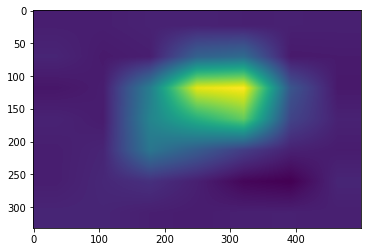

In [39]:
grad_cam_image_conv5 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image_conv5)
plt.show()

In [40]:
rect = get_bbox(grad_cam_image_conv5)
rect

array([[136, 288],
       [ 70,  88],
       [393, -19],
       [459, 180]])

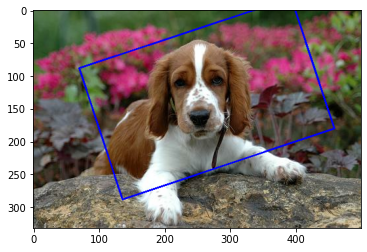

In [41]:
image = copy.deepcopy(item['image'])
output_grad_cam_conv5 = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(output_grad_cam_conv5)
plt.show()

In [42]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[-0.0572289156626506, 0.14, 0.8674698795180723, 0.918]

In [43]:
item['objects']['bbox']

array([[0.13554217, 0.146     , 0.9879518 , 0.826     ]], dtype=float32)

In [44]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.6210955320456888

#### conv4_block3_out 이용

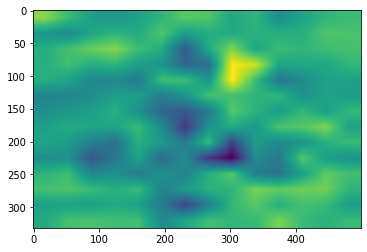

In [45]:
grad_cam_image_conv4 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image_conv4)
plt.show()

In [46]:
rect = get_bbox(grad_cam_image_conv4)
rect

array([[499, 331],
       [  0, 331],
       [  0,   0],
       [499,   0]])

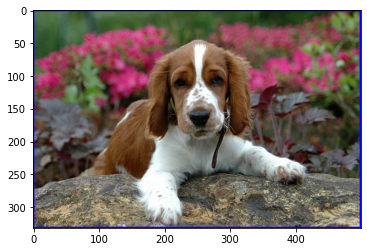

In [47]:
image = copy.deepcopy(item['image'])
output_grad_cam_conv4 = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(output_grad_cam_conv4)
plt.show()

In [48]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.0, 0.0, 0.9969879518072289, 0.998]

In [49]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.5825548242323544

#### conv3_block3_out 이용

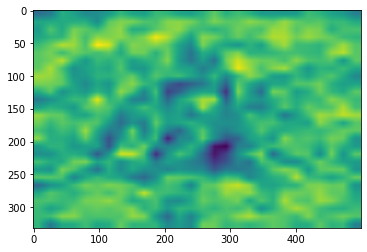

In [50]:
grad_cam_image_conv3 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image_conv3)
plt.show()

In [51]:
rect = get_bbox(grad_cam_image_conv3)
rect

array([[  0, 297],
       [ -2, 283],
       [ 38, 273],
       [ 41, 288]])

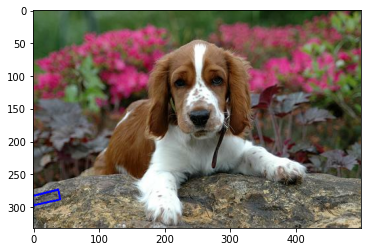

In [52]:
image = copy.deepcopy(item['image'])
output_grad_cam_conv3 = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(output_grad_cam_conv3)
plt.show()

In [53]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.822289156626506, -0.004, 0.8945783132530121, 0.082]

In [54]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.0

## 5. 결과 정리

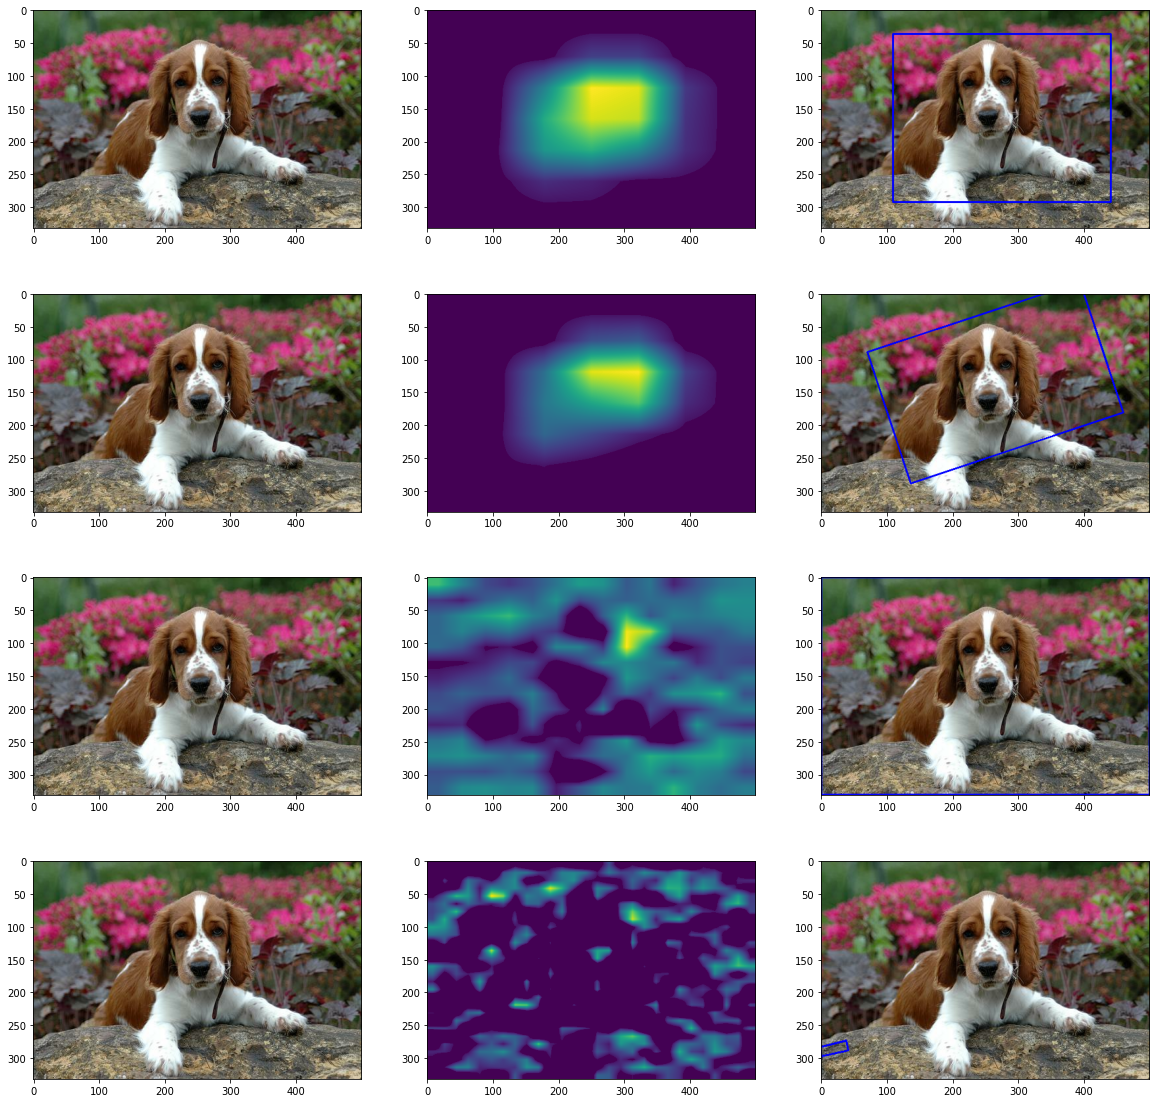

In [55]:
plt.figure(figsize=(20,20))
for i in range(4):
    plt.subplot(4, 3, i*3+1)
    plt.imshow(item['image'])

plt.subplot(4, 3, 2)
plt.imshow(cam_image)

plt.subplot(4, 3, 3)
plt.imshow(output_cam)

plt.subplot(4, 3, 5)
plt.imshow(grad_cam_image_conv5)

plt.subplot(4, 3, 6)
plt.imshow(output_grad_cam_conv5)

plt.subplot(4, 3, 8)
plt.imshow(grad_cam_image_conv4)

plt.subplot(4, 3, 9)
plt.imshow(output_grad_cam_conv4)

plt.subplot(4, 3, 11)
plt.imshow(grad_cam_image_conv3)

plt.subplot(4, 3, 12)
plt.imshow(output_grad_cam_conv3)

plt.show()

||Iou|
|---|:---:|
|CAM|0.709|
|Grad-CAM (conv5)|0.621|
|Grad-CAM (conv4)|0.583|
|Grad-CAM (conv3)|0.0|

- Grad-CAM 보다 CAM의 IoU가 더 높게 나왔다.
- bbox로 시각화해보니 육안으로도 CAM의 결과가 더 좋아보인다.

## 6. 회고